# Housekeeping (Importing libraries, loading datasets)

In [1]:
from utility import random_number_generator as rng
from utility import variance_reduction as vr

import pandas as pd
import numpy as np
from datetime import datetime
import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
from scipy.stats import norm

In [2]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [3]:
# Load Market Yield on U.S. Treasury Securities at X-Year Constant Maturity, Quoted on an Investment Basis
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

# combine them all
yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

# I. Exploratory Data Analysis

In [4]:
# check formissing values and prepare for imputation
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [5]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
        SOFR
count   1719
unique   188
top     0.05
freq     188


In [6]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


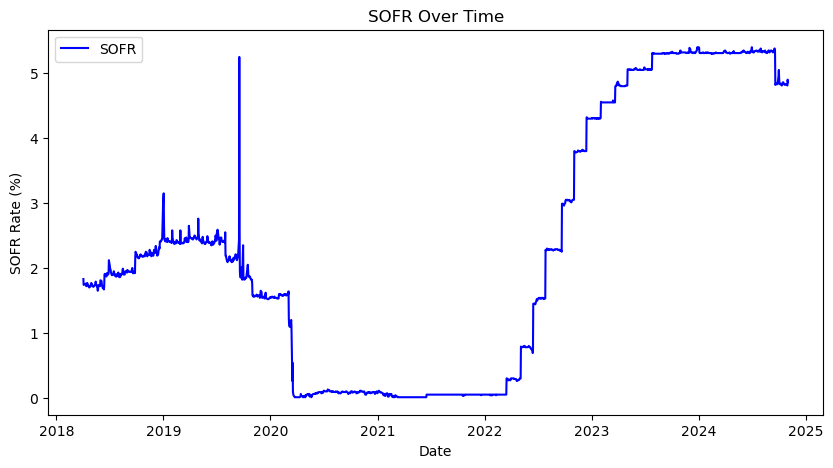

In [7]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Plot SOFR over time
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

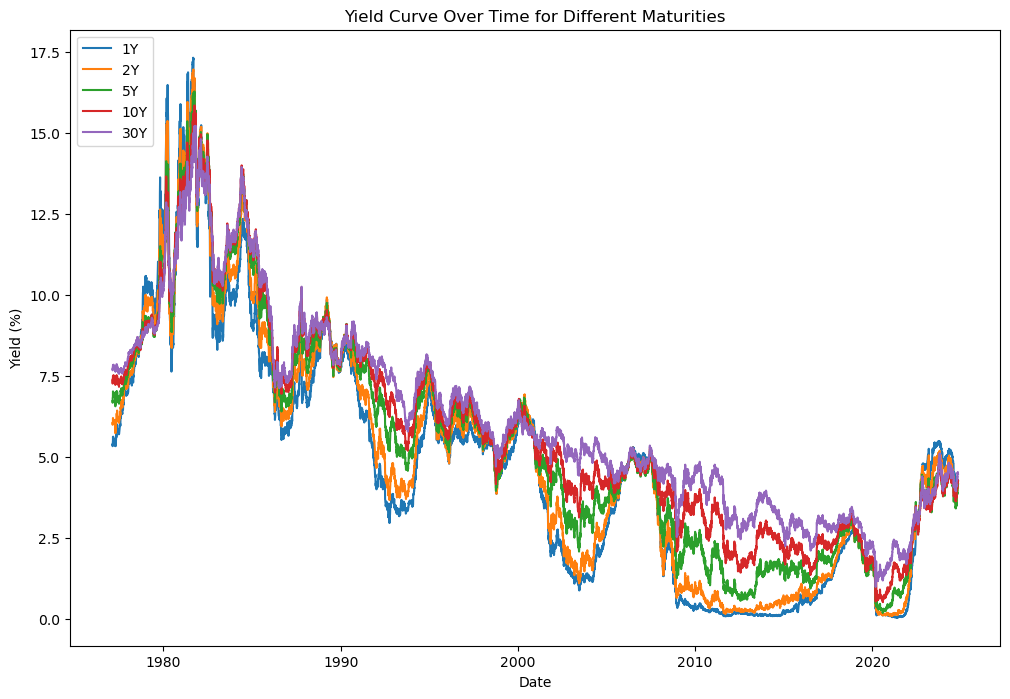

In [8]:
# Ensure all yield curve columns are numeric and handle any non-numeric values
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

yc = yc.interpolate(method='time').dropna()  # Interpolate missing values based on time index

plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

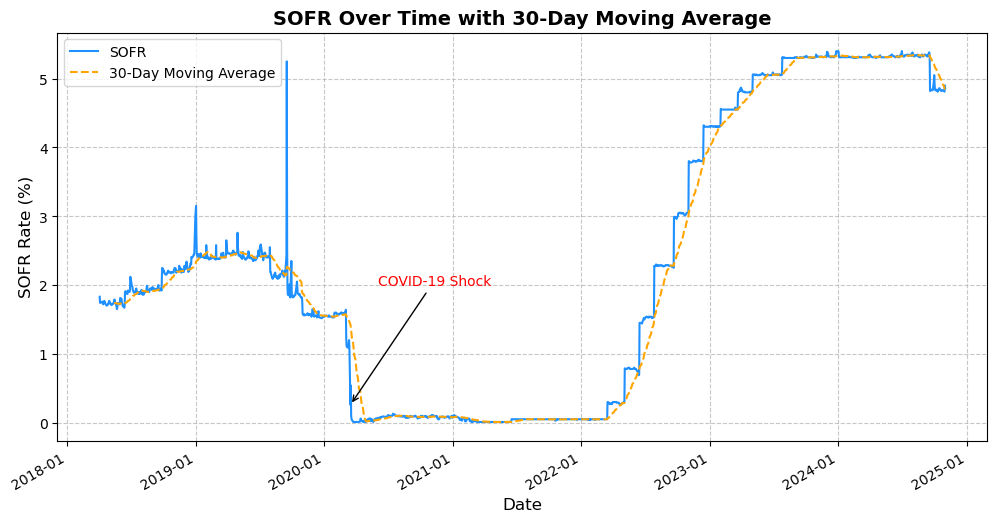

In [9]:
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna() 

sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')
annot_date = datetime(2020, 3, 16)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

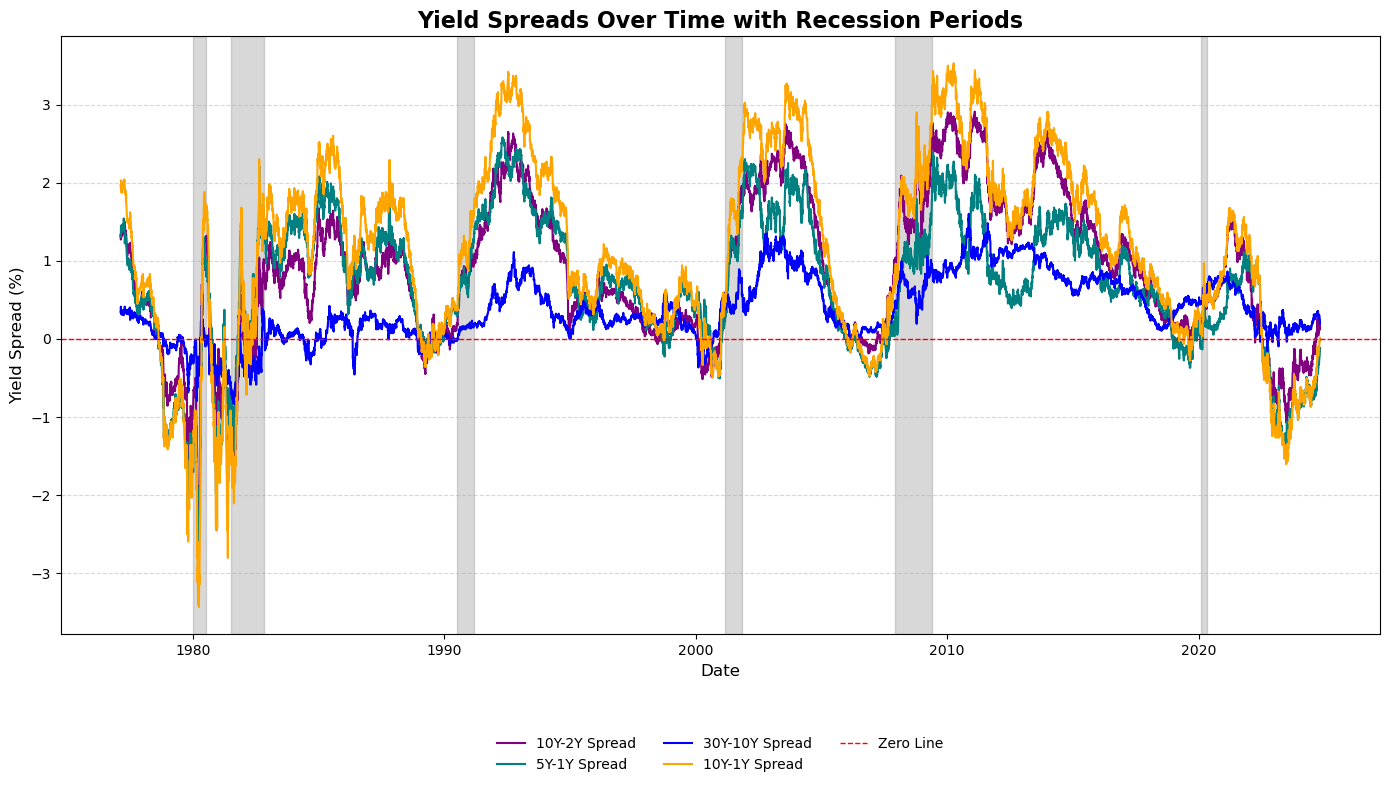

In [10]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01') 
]

start_date = '1975-01-01'
filtered_yc = yc[yc.index >= start_date]
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

plt.figure(figsize=(14, 8))
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

for start, end in recession_periods:
    if start >= start_date: 
        plt.axvspan(start, end, color='gray', alpha=0.3)

plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

are all these spreads required to be plotted? whats the significance?

# II: Construction of Forward Rate Curves

Forward Rate Curve:
               1Y-2Y     2Y-5Y    5Y-10Y   10Y-30Y
DATE                                              
1977-02-15  6.694009  7.175754  8.003838  7.870404
1977-02-16  6.643647  7.155755  7.983839  7.835380
1977-02-17  6.654136  7.125755  7.853263  7.875587
1977-02-18  6.744388  7.329690  8.003259  7.935427
1977-02-21  6.728915  7.339630  8.003176  7.942927


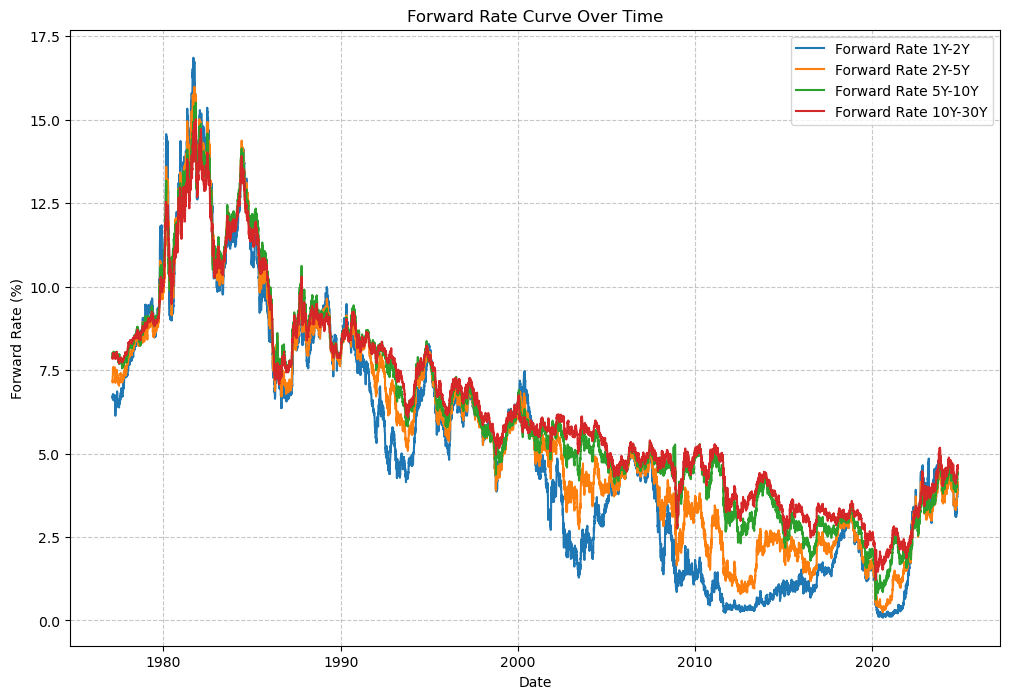

In [11]:
def calculate_forward_rate(yield_curve, t1, t2):
    # Spot rates for maturities t1 and t2
    r_t1 = yield_curve[f"{t1}Y"]
    r_t2 = yield_curve[f"{t2}Y"]
    
    forward_rate = ((1 + r_t2 / 100) ** t2 / (1 + r_t1 / 100) ** t1) ** (1 / (t2 - t1)) - 1
    return forward_rate * 100

forward_curve = pd.DataFrame(index=yc.index)
forward_curve['1Y-2Y'] = calculate_forward_rate(yc, 1, 2)
forward_curve['2Y-5Y'] = calculate_forward_rate(yc, 2, 5)
forward_curve['5Y-10Y'] = calculate_forward_rate(yc, 5, 10)
forward_curve['10Y-30Y'] = calculate_forward_rate(yc, 10, 30)

print("Forward Rate Curve:")
print(forward_curve.head())

plt.figure(figsize=(12, 8))
for column in forward_curve.columns:
    plt.plot(forward_curve.index, forward_curve[column], label=f"Forward Rate {column}")

plt.title("Forward Rate Curve Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [12]:
forward_curve.tail()

,1Y-2Y,2Y-5Y,5Y-10Y,10Y-30Y
DATE,,,,
2024-10-25,3.930311,4.043342,4.430311,4.640243
2024-10-28,3.960245,4.103334,4.450278,4.655225
2024-10-29,3.930311,4.110000,4.450278,4.640207
2024-10-30,4.020162,4.133334,4.440216,4.590144
2024-10-31,4.050116,4.143334,4.410162,4.565130


# III. Analysis of Yield Curve Movements using PCA

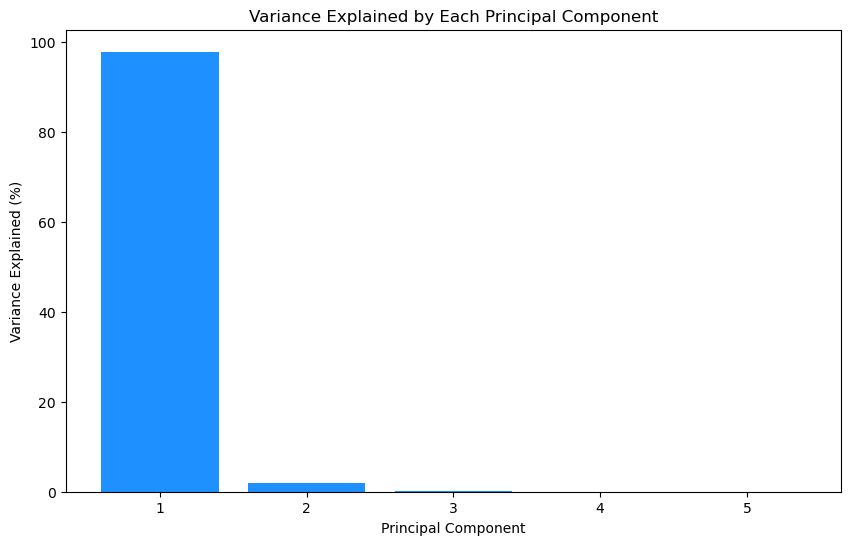

In [13]:
yield_data = yc[['1Y', '2Y', '5Y', '10Y', '30Y']]

scaler = StandardScaler()
yield_data_std = scaler.fit_transform(yield_data)

pca = PCA(n_components=5)
pca.fit(yield_data_std)
yield_pca = pca.transform(yield_data_std)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, color='dodgerblue')
plt.title("Variance Explained by Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.show()

As expected, we see that most of the variance has been captured by the first PC. With the rest being captured by 2 and 3.

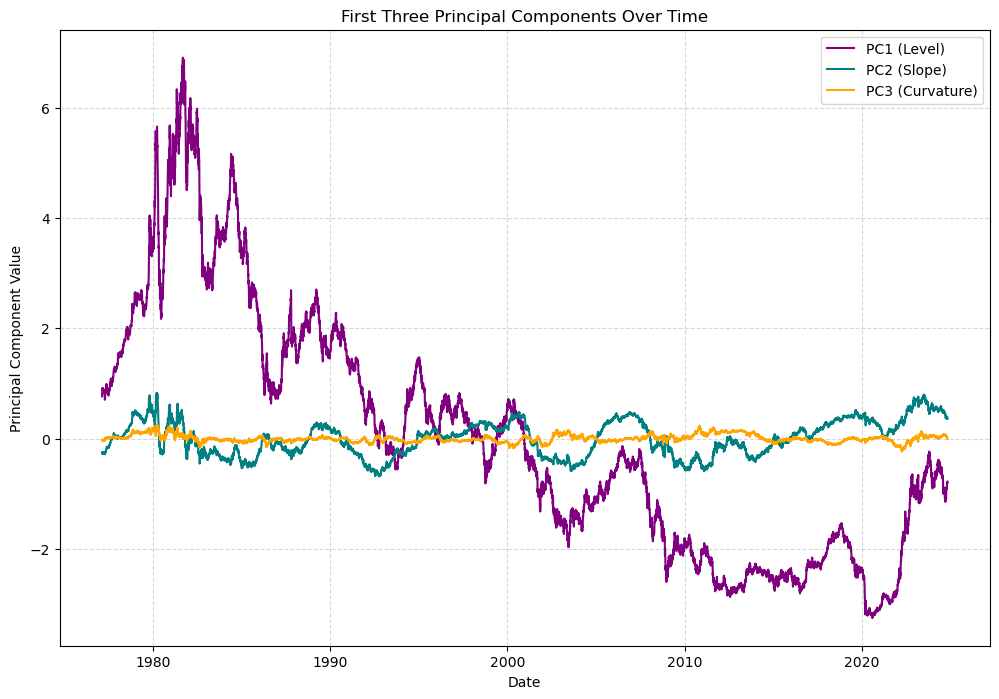

In [14]:
# Convert the PCA components to a DataFrame for further analysis
pca_df = pd.DataFrame(yield_pca, index=yield_data.index, columns=[f'PC{i+1}' for i in range(yield_pca.shape[1])])

plt.figure(figsize=(12, 8))
plt.plot(pca_df.index, pca_df['PC1'], label='PC1 (Level)', color='purple')
plt.plot(pca_df.index, pca_df['PC2'], label='PC2 (Slope)', color='teal')
plt.plot(pca_df.index, pca_df['PC3'], label='PC3 (Curvature)', color='orange')
plt.title("First Three Principal Components Over Time")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The principal components are used to calibrate the volatility structure of the HJM model. This ensures that the stochastic simulation of forward rates reflects historical yield curve dynamics. Each PC is associated with a factor in the HJM model, which influences how forward rates evolve over time.

# IV: Stochastic Modeling with the HJM Framework

In [15]:
# parameters for the simulation
# n_steps = 100
# n_simulations = 10
# dt = 1/252
# volatility = 0.01

## i. Incorporating PCA factors for Volatility Calcualtions

In [16]:
# eigenvectors: factor loadings
# eigenvalues: explained variance

def calculate_volatility(t, T_index, eigenvectors, eigenvalues, n_factors=3):

    eigenvalues_rescaled = eigenvalues / np.sum(eigenvalues)
    volatility = 0
    for i in range(min(n_factors, len(eigenvalues))):
        # volatility += eigenvectors[i, T_index] * np.sqrt(eigenvalues[i])
        term = eigenvectors[i, T_index] * np.sqrt(eigenvalues_rescaled[i])
        volatility += term
    return volatility

In [17]:
print("Eigenvalues:", pca.explained_variance_)
print("Eigenvectors (first row):", pca.components_[0])

Eigenvalues: [4.89276297e+00 1.02528574e-01 4.43716980e-03 4.62754023e-04
 2.10236634e-04]
Eigenvectors (first row): [0.44290828 0.44869541 0.4516568  0.44919097 0.4435519 ]


## iii. Monte Carlo Simulation

In [25]:
print("Select a random number generation method:")
print("1: Standard Normal Distribution")
print("2: Uniform Distribution")
print("3: Random Numbers Std Numpy Implementation")
print("4: Sobol Sequence")
print("5: Halton Sequence")
print("6: Latin Hypercube Sequence")
user_choice = int(input("Enter your choice (1/2/3/4/5/6): "))
rng_methods = {
    1: "normal",
    2: "uniform",
    3: "rand",
    4: "sobol",
    5: "halton",
    6: "lhs",
}
rng_method = rng_methods.get(user_choice, "normal")
print(f"Using RNG Method: {rng_method}")

Select a random number generation method:
1: Standard Normal Distribution
2: Uniform Distribution
3: Random Numbers Std Numpy Implementation
4: Sobol Sequence
5: Halton Sequence
6: Latin Hypercube Sequence
Using RNG Method: lhs


RNG Method: lhs, Step 1
dW Mean = 0.000355, Std Dev = 0.060890, Shape = (5, 10)
dW Sample Values (First Few): [[-0.07437181  0.01059629 -0.11365501  0.04986083  0.07828008]
 [-0.04358274 -0.12894412 -0.00980977 -0.07819882 -0.02292307]
 [-0.07000793  0.05428726 -0.09154188  0.08910969  0.0198282 ]
 [ 0.06283997 -0.05254683  0.0878451  -0.09199571 -0.05916409]
 [-0.00265214  0.14101811 -0.03622399  0.01666935  0.06600161]]
RNG Method: lhs, Step 2
dW Mean = -0.003296, Std Dev = 0.063498, Shape = (5, 10)
dW Sample Values (First Few): [[-0.03505787  0.05207827  0.08312471 -0.02520213 -0.05835172]
 [ 0.09407046  0.0505393   0.01424068 -0.01215886  0.02908518]
 [ 0.00081978 -0.02684601 -0.04622541  0.0871055  -0.07440591]
 [-0.09563421 -0.04751624  0.02628324 -0.01511595  0.06012007]
 [ 0.06981821 -0.03538429  0.03926922 -0.01228092  0.08328654]]
RNG Method: lhs, Step 3
dW Mean = -0.000794, Std Dev = 0.062413, Shape = (5, 10)
dW Sample Values (First Few): [[-0.00663953 -0.02255545  0.0272761

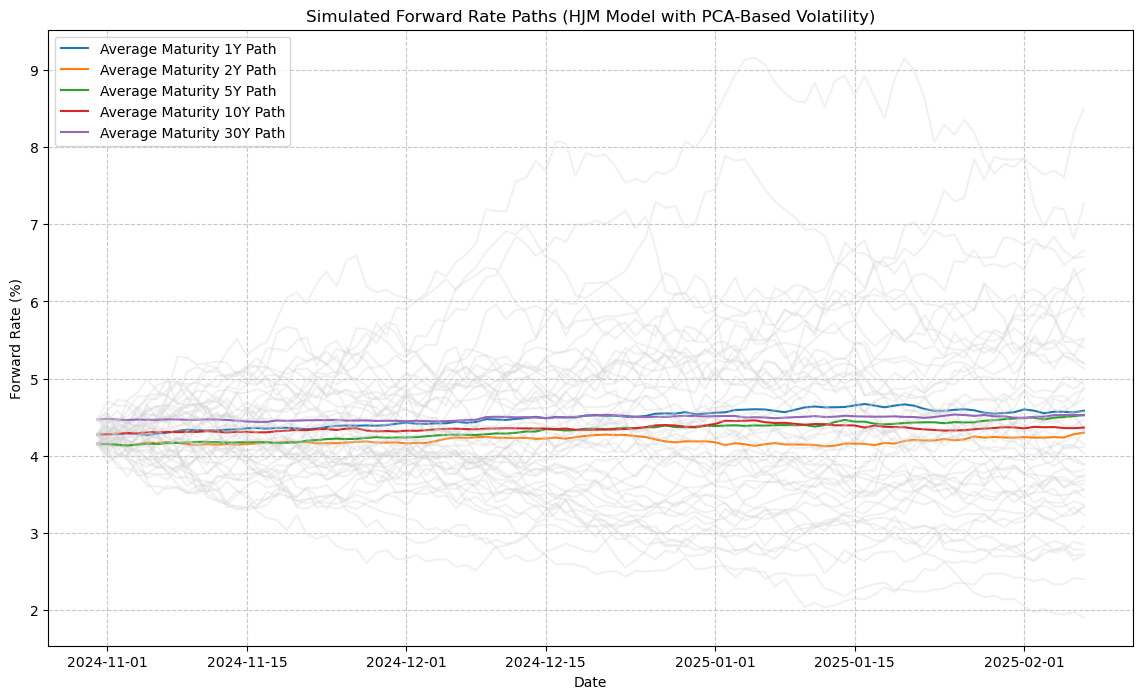

In [26]:
n_steps = 100
n_simulations = 10
dt = 1 / 252

available_maturities = ['1Y', '2Y', '5Y', '10Y', '30Y']
initial_forward_rates = yc[available_maturities].iloc[-1].values
n_maturities = len(initial_forward_rates)
simulated_forward_rates = np.zeros((n_steps, n_maturities, n_simulations))
simulated_forward_rates[0, :, :] = initial_forward_rates[:, np.newaxis]

# MONTE CARLO SIMULATION
for i in range(1, n_steps):

   #dW = np.random.normal(0, np.sqrt(dt), (n_maturities, n_simulations))
    dW = rng.generate_random_numbers(rng_method, (n_maturities, n_simulations), dt=dt)
    print(f"RNG Method: {rng_method}, Step {i}")
    print(f"dW Mean = {dW.mean():.6f}, Std Dev = {dW.std():.6f}, Shape = {dW.shape}")
    print(f"dW Sample Values (First Few): {dW[:5, :5]}")
    
    for j in range(n_maturities):
        volatility = calculate_volatility(i * dt, j, pca.components_, pca.explained_variance_)
        drift = 0 
        diffusion = volatility * dW[j, :]
        simulated_forward_rates[i, j, :] = simulated_forward_rates[i-1, j, :] * np.exp(drift * dt + diffusion)

dates = pd.date_range(start=yc.index[-1], periods=n_steps, freq='D')
simulated_paths = {f'Maturity {m}Y': pd.DataFrame(simulated_forward_rates[:, j, :], index=dates) for j, m in enumerate([1, 2, 5, 10, 30])}

plt.figure(figsize=(14, 8))
for maturity, paths in simulated_paths.items():
    plt.plot(paths.index, paths.mean(axis=1), label=f"Average {maturity} Path")
    for path in paths.columns:
        plt.plot(paths.index, paths[path], color='lightgray', alpha=0.3)

plt.title("Simulated Forward Rate Paths (HJM Model with PCA-Based Volatility)")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Computational Time Comparison

# ...

# ...

# ...

# V. Pricing IR Derivatives

In [20]:
from utility.variance_reduction import price_with_variance_reduction

print("Select a variance reduction method:")
print("1: Standard Monte Carlo")
print("2: Antithetic Variates")
print("3: Control Variates")

user_choice = int(input("Enter your choice (1/2/3): "))
vr_methods = {1: "standard", 2: "antithetic", 3: "control"}
vr_method = vr_methods.get(user_choice, "standard")

cap_rate = 0.03
floor_rate = 0.02
discount_rate = 0.01
dt = 1 / 252  # Time step
discount_factors = np.exp(-discount_rate * np.arange(1, n_steps+1) * dt)

# control placeholder
analytical_price = 0.05  
initial_forward_rates = yc[available_maturities].iloc[-1].values  # last row of spot rates
dt = 1 / 252  
volatility = 0.01 
n_steps = 100 
n_simulations = 10 

cap_price, cap_std_dev = price_with_variance_reduction(
    vr_method,
    simulated_forward_rates,
    cap_rate,
    discount_factors,
    analytical_price if vr_method == "control" else None,
    initial_forward_rates=initial_forward_rates,
    dt=dt,
    volatility=volatility,
    n_steps=n_steps,
    n_simulations=n_simulations
)

floor_price, floor_std_dev = price_with_variance_reduction(
    vr_method,
    simulated_forward_rates,
    floor_rate,
    discount_factors,
    analytical_price if vr_method == "control" else None,
    initial_forward_rates=initial_forward_rates,
    dt=dt,
    volatility=volatility,
    n_steps=n_steps,
    n_simulations=n_simulations
)

print(f"Variance Reduction Method: {vr_method.capitalize()}")
print(f"Cap Price: {cap_price:.4f}, Standard Deviation: {cap_std_dev:.4f}")
print(f"Floor Price: {floor_price:.4f}, Standard Deviation: {floor_std_dev:.4f}")

Select a variance reduction method:
1: Standard Monte Carlo
2: Antithetic Variates
3: Control Variates
Variance Reduction Method: Standard
Cap Price: 432.1657, Standard Deviation: 80.4463
Floor Price: 433.1637, Standard Deviation: 80.4463
